# Data Preprocessing for LitBank NER

## Overview
This notebook prepares the LitBank dataset for transformer-based Named Entity Recognition (NER).

**Content**
1. Load LitBank data from nested folder structure
2. Parse BIO-tagged annotations (PER, LOC, GPE, ORG, FAC, VEH)
3. Convert to JSON format for transformer training
4. Generate statistics and visualizations

Transformers need data in specific formats (token sequences + aligned labels)
Understanding entity distribution helps diagnose model performance later

In [1]:
# Import required libraries
import os
import json
from pathlib import Path
from typing import List, Dict, Tuple
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configure paths - UPDATE THIS with your LitBank location
RAW_DATA_PATH = Path("../data/raw")  # Path to LitBank folders (train/dev/test)
PROCESSED_DATA_PATH = Path("../data/processed")
PROCESSED_DATA_PATH.mkdir(parents=True, exist_ok=True)

print("✓ Libraries imported")
print(f"✓ Will save processed data to: {PROCESSED_DATA_PATH.absolute()}")

✓ Libraries imported
✓ Will save processed data to: c:\Users\niw\Documents\CAS NLP Mod4\Mod4_Project\module4-transformers\notebooks\..\data\processed


## Download and Prepare LitBank Dataset

Download the English LitBank dataset from HuggingFace and convert it to the BIO format expected by the preprocessing pipeline.

In [2]:
# Download and prepare LitBank dataset from HuggingFace
from datasets import load_dataset

# Create raw data directory structure
RAW_DATA_PATH.mkdir(parents=True, exist_ok=True)
for split_name in ['train', 'dev', 'test']:
    (RAW_DATA_PATH / split_name).mkdir(parents=True, exist_ok=True)

print("Downloading LitBank dataset from HuggingFace...")
print("This may take a moment on first run (dataset will be cached).\n")

# Load dataset from HuggingFace (using split_0 configuration)
dataset = load_dataset("coref-data/litbank_raw", "split_0")

# Map validation split to dev
split_mapping = {
    'train': 'train',
    'validation': 'dev',
    'test': 'test'
}

print("Converting to BIO format and saving to files...")
print("Strategy: Using cascading layers - if layer 1 is 'O', check layer 2, etc.\n")

# Track statistics about which layers are being used
layer_usage_stats = {layer: 0 for layer in range(5)}
total_tokens_processed = 0

# Process each split
for hf_split, our_split in split_mapping.items():
    split_data = dataset[hf_split]
    split_dir = RAW_DATA_PATH / our_split
    
    print(f"Processing {our_split} split ({len(split_data)} documents)...")
    
    # Process each document
    for idx, example in enumerate(split_data):
        doc_name = example['doc_name']
        sentences = example['sentences']
        entities = example['entities']
        
        # Create output file for this document
        output_file = split_dir / f"{doc_name}.tsv"
        
        with open(output_file, 'w', encoding='utf-8') as f:
            # entities is a list of lists (one list per sentence)
            # Each sentence has a list of dicts: [{'token': 'word', 'bio_tags': [...]}, ...]
            
            for sent_idx, sentence in enumerate(sentences):
                # Get entity annotations for this sentence
                if sent_idx < len(entities):
                    entity_annotations = entities[sent_idx]
                    
                    # Process each token in the sentence
                    for token_dict in entity_annotations:
                        token = token_dict['token']
                        bio_tags = token_dict['bio_tags']
                        
                        # Cascading layer strategy:
                        # Try each layer in order. If layer has 'O', try next layer.
                        # If layer has a non-O entity tag, use it.
                        # This allows us to capture nested entities from multiple layers.
                        tag = 'O'
                        layer_used = -1
                        
                        for layer_idx, t in enumerate(bio_tags):
                            if t and t.strip():  # Non-empty tag
                                if t != 'O':
                                    # Found a non-O entity tag, use it
                                    tag = t
                                    layer_used = layer_idx
                                    break
                                elif tag == 'O':
                                    # Update to this layer's O (in case all layers are O)
                                    tag = 'O'
                                    layer_used = layer_idx
                        
                        # Track statistics
                        if layer_used >= 0:
                            layer_usage_stats[layer_used] += 1
                        total_tokens_processed += 1
                        
                        f.write(f"{token}\t{tag}\n")
                else:
                    # Fallback: if no entity annotations for this sentence, use 'O' tags
                    for token in sentence:
                        f.write(f"{token}\tO\n")
                        total_tokens_processed += 1
                
                # Add blank line between sentences
                f.write("\n")
    
    print(f"  ✓ Saved {len(split_data)} documents to {split_dir}/")

print(f"\n{'='*60}")
print("Dataset download and preparation complete!")
print(f"{'='*60}")
print(f"\nRaw data saved to: {RAW_DATA_PATH.absolute()}")

# Display layer usage statistics
print(f"\n{'='*60}")
print("LAYER USAGE STATISTICS")
print(f"{'='*60}")
print(f"Total tokens processed: {total_tokens_processed:,}")
print("\nTokens extracted from each annotation layer:")
for layer, count in sorted(layer_usage_stats.items()):
    if count > 0:
        percentage = (count / total_tokens_processed * 100) if total_tokens_processed > 0 else 0
        print(f"  Layer {layer}: {count:,} tokens ({percentage:.2f}%)")

print("\nNote: Higher layer numbers indicate tokens where layer 0 was 'O'")
print("and we found an entity annotation in a deeper layer.")
print("\nYou can now run the preprocessing pipeline below.")

This may take a moment on first run (dataset will be cached).

Converting to BIO format and saving to files...
Strategy: Using cascading layers - if layer 1 is 'O', check layer 2, etc.

Processing train split (80 documents)...
  ✓ Saved 80 documents to ..\data\raw\train/
Processing dev split (10 documents)...
  ✓ Saved 10 documents to ..\data\raw\dev/
Processing test split (10 documents)...
  ✓ Saved 10 documents to ..\data\raw\test/

Dataset download and preparation complete!

Raw data saved to: c:\Users\niw\Documents\CAS NLP Mod4\Mod4_Project\module4-transformers\notebooks\..\data\raw

LAYER USAGE STATISTICS
Total tokens processed: 210,532

Tokens extracted from each annotation layer:
  Layer 0: 28,867 tokens (13.71%)
  Layer 1: 7,239 tokens (3.44%)
  Layer 2: 1,155 tokens (0.55%)
  Layer 3: 154,041 tokens (73.17%)
  Layer 4: 19,230 tokens (9.13%)

Note: Higher layer numbers indicate tokens where layer 0 was 'O'
and we found an entity annotation in a deeper layer.

You can now run th

## 1. Helper Functions

### Understanding BIO Tagging
BIO (Beginning-Inside-Outside) format marks entity boundaries:
- `B-PER`: **B**eginning of a person name
- `I-PER`: **I**nside/continuation of a person name
- `O`: **O**utside any entity (regular words)

In [3]:
def load_bio_file(file_path: Path) -> Tuple[List[str], List[str]]:
    """
    Load a single BIO-tagged file.
    
    WHY: LitBank stores tokens and labels in separate columns (TSV format).
    We need to parse them into parallel lists for training.
    
    Args:
        file_path: Path to .tsv or .txt file with BIO annotations
        
    Returns:
        tokens: List of words/tokens ["John", "visited", "Paris"]
        labels: List of BIO tags ["B-PER", "O", "B-LOC"]
    """
    tokens = []
    labels = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                
                # Empty lines separate sentences - skip them
                if not line:
                    continue
                
                # Each line: TOKEN\tLABEL or TOKEN LABEL
                parts = line.split('\t') if '\t' in line else line.split()
                
                if len(parts) >= 2:
                    token = parts[0]
                    label = parts[1]
                    tokens.append(token)
                    labels.append(label)
    
    except Exception as e:
        print(f"Warning: Could not read {file_path}: {e}")
        return [], []
    
    return tokens, labels


def split_into_sentences(tokens: List[str], labels: List[str], max_length: int = 512) -> List[Dict]:
    """
    Split long documents into sentence-level examples.
    
    WHY: Transformers have maximum input lengths (512 tokens for XLM-RoBERTa).
    We need to chunk documents while preserving entity boundaries.
    
    Args:
        tokens: Full document tokens
        labels: Corresponding BIO labels
        max_length: Maximum tokens per sequence (leave room for special tokens)
        
    Returns:
        List of examples: [{"tokens": [...], "labels": [...]}, ...]
    """
    examples = []
    current_tokens = []
    current_labels = []
    
    for token, label in zip(tokens, labels):
        current_tokens.append(token)
        current_labels.append(label)
        
        # Split on sentence boundaries (periods, question marks, exclamation)
        # OR when approaching max length
        if (token in ['.', '!', '?'] and len(current_tokens) > 10) or len(current_tokens) >= max_length - 10:
            examples.append({
                "tokens": current_tokens.copy(),
                "labels": current_labels.copy()
            })
            current_tokens = []
            current_labels = []
    
    # Add remaining tokens
    if current_tokens:
        examples.append({
            "tokens": current_tokens,
            "labels": current_labels
        })
    
    return examples


def load_split(split_path: Path, split_name: str) -> List[Dict]:
    """
    Load all files from a split (train/dev/test) directory.
    
    WHY: LitBank organizes data in nested folders. We need to recursively
    find all annotation files and combine them.
    
    Args:
        split_path: Path to train/dev/test folder
        split_name: Name for progress display ("train", "dev", "test")
        
    Returns:
        List of sentence-level examples
    """
    all_examples = []
    
    # Find all .tsv or .txt files (LitBank uses various extensions)
    file_patterns = ['**/*.tsv', '**/*.txt', '**/*.bio']
    files = []
    for pattern in file_patterns:
        files.extend(split_path.glob(pattern))
    
    print(f"\nProcessing {split_name} split: found {len(files)} files")
    
    for file_path in tqdm(files, desc=f"Loading {split_name}"):
        tokens, labels = load_bio_file(file_path)
        
        if tokens:  # Skip empty files
            # Split into sentences and add to dataset
            examples = split_into_sentences(tokens, labels)
            all_examples.extend(examples)
    
    print(f"✓ Loaded {len(all_examples)} sentence examples from {split_name}")
    return all_examples


print("✓ Helper functions defined")

✓ Helper functions defined


## 2. Load and Process LitBank Data

**Entity types in LitBank:**
- **PER**: Person (characters, authors)
- **LOC**: Location (cities, regions, not politically defined)
- **GPE**: Geo-Political Entity (countries, states)
- **ORG**: Organization (companies, institutions)
- **FAC**: Facility (buildings, structures)
- **VEH**: Vehicle (ships, cars)

In [4]:
# Check if raw data exists
if not RAW_DATA_PATH.exists():
    print(f"⚠️  Raw data path not found: {RAW_DATA_PATH.absolute()}")
    print("Please update RAW_DATA_PATH in the first code cell with your LitBank location.")
    print("\nExpected structure:")
    print("  data/raw/train/  (or nested subfolders with .tsv/.txt files)")
    print("  data/raw/dev/")
    print("  data/raw/test/")
else:
    print(f"✓ Found raw data directory: {RAW_DATA_PATH.absolute()}")
    print("\nDirectory contents:")
    for item in RAW_DATA_PATH.iterdir():
        print(f"  - {item.name}")

✓ Found raw data directory: c:\Users\niw\Documents\CAS NLP Mod4\Mod4_Project\module4-transformers\notebooks\..\data\raw

Directory contents:
  - dev
  - test
  - train


In [5]:
# Load train, dev, test splits
train_data = load_split(RAW_DATA_PATH / "train", "train")
dev_data = load_split(RAW_DATA_PATH / "dev", "dev")
test_data = load_split(RAW_DATA_PATH / "test", "test")

print(f"\n{'='*50}")
print(f"Dataset Summary:")
print(f"  Train: {len(train_data)} examples")
print(f"  Dev:   {len(dev_data)} examples")
print(f"  Test:  {len(test_data)} examples")
print(f"{'='*50}")


Processing train split: found 80 files


Loading train: 100%|██████████| 80/80 [00:02<00:00, 39.50it/s]


✓ Loaded 5577 sentence examples from train

Processing dev split: found 10 files


Loading dev: 100%|██████████| 10/10 [00:00<00:00, 36.61it/s]


✓ Loaded 747 sentence examples from dev

Processing test split: found 10 files


Loading test: 100%|██████████| 10/10 [00:00<00:00, 37.01it/s]

✓ Loaded 693 sentence examples from test

Dataset Summary:
  Train: 5577 examples
  Dev:   747 examples
  Test:  693 examples


## 3. Create Label Mapping

Transformers output numbers, not strings. The following cell maps each BIO tag to an integer ID:
- "O" → 0
- "B-PER" → 1
- "I-PER" → 2
- etc.

Also use `-100` as a special label for subword tokens.

In [6]:
def create_label_mapping(datasets: List[List[Dict]]) -> Dict[str, int]:
    """
    Create a mapping from BIO tags to integer IDs.
    
    WHY: Neural networks output numbers. We need consistent mapping across
    train/dev/test so the model learns the same label IDs.
    
    Args:
        datasets: List of datasets (train, dev, test)
        
    Returns:
        label2id: {"O": 0, "B-PER": 1, ...}
    """
    all_labels = set()
    
    # Collect all unique labels from all datasets
    for dataset in datasets:
        for example in dataset:
            all_labels.update(example["labels"])
    
    # Sort for consistent ordering (O first, then B- tags, then I- tags)
    sorted_labels = sorted(all_labels, key=lambda x: (x != 'O', x))
    
    # Create mapping
    label2id = {label: idx for idx, label in enumerate(sorted_labels)}
    
    return label2id


# Create mapping
label2id = create_label_mapping([train_data, dev_data, test_data])
id2label = {v: k for k, v in label2id.items()}  # Reverse mapping for predictions

print(f"\nFound {len(label2id)} unique labels:")
for label, idx in sorted(label2id.items(), key=lambda x: x[1]):
    print(f"  {idx:2d}: {label}")

# Save label mapping
label_mapping = {
    "label2id": label2id,
    "id2label": id2label
}

with open(PROCESSED_DATA_PATH / "label_mapping.json", 'w', encoding='utf-8') as f:
    json.dump(label_mapping, f, indent=2, ensure_ascii=False)

print(f"\n✓ Saved label mapping to {PROCESSED_DATA_PATH / 'label_mapping.json'}")


Found 13 unique labels:
   0: O
   1: B-FAC
   2: B-GPE
   3: B-LOC
   4: B-ORG
   5: B-PER
   6: B-VEH
   7: I-FAC
   8: I-GPE
   9: I-LOC
  10: I-ORG
  11: I-PER
  12: I-VEH

✓ Saved label mapping to ..\data\processed\label_mapping.json


## 4. Save Processed Data

JSON format is needed because:
- Human-readable (easy to inspect)
- Compatible with Hugging Face datasets
- Preserves structure (lists, nested data)

In [7]:
def save_dataset(data: List[Dict], output_path: Path, label2id: Dict[str, int]):
    """
    Save dataset to JSON with integer label IDs.
    
    Args:
        data: List of examples with tokens and labels
        output_path: Where to save JSON file
        label2id: Label mapping to convert strings to IDs
    """
    # Convert string labels to IDs
    processed_data = []
    for example in data:
        processed_data.append({
            "tokens": example["tokens"],
            "ner_tags": [label2id[label] for label in example["labels"]]
        })
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(processed_data, f, indent=2, ensure_ascii=False)
    
    print(f"✓ Saved {len(processed_data)} examples to {output_path}")


# Save all splits
save_dataset(train_data, PROCESSED_DATA_PATH / "train_data.json", label2id)
save_dataset(dev_data, PROCESSED_DATA_PATH / "dev_data.json", label2id)
save_dataset(test_data, PROCESSED_DATA_PATH / "test_data.json", label2id)

print(f"\n{'='*50}")
print("All data saved successfully!")
print(f"Location: {PROCESSED_DATA_PATH.absolute()}")
print(f"{'='*50}")

✓ Saved 5577 examples to ..\data\processed\train_data.json
✓ Saved 747 examples to ..\data\processed\dev_data.json
✓ Saved 693 examples to ..\data\processed\test_data.json

All data saved successfully!
Location: c:\Users\niw\Documents\CAS NLP Mod4\Mod4_Project\module4-transformers\notebooks\..\data\processed


In [8]:
def compute_statistics(data: List[Dict], split_name: str) -> Dict:
    """
    Compute dataset statistics.
    
    Returns:
        Dictionary with counts, averages, and entity distribution
    """
    total_tokens = 0
    total_entity_tokens = 0  # Tokens that are part of entities (B- or I-)
    total_non_entity_tokens = 0  # Tokens with 'O' tag
    total_entities = 0
    entity_type_counts = Counter()
    entity_type_token_counts = Counter()  # Count all tokens (B- and I-) per entity type
    entity_type_b_counts = Counter()  # Count B- tags per entity type
    entity_type_i_counts = Counter()  # Count I- tags per entity type
    sequence_lengths = []
    
    for example in data:
        tokens = example["tokens"]
        labels = example["labels"]
        
        total_tokens += len(tokens)
        sequence_lengths.append(len(tokens))
        
        # Count entities and token-level statistics
        for label in labels:
            if label == 'O':
                total_non_entity_tokens += 1
            else:
                total_entity_tokens += 1
                # Extract entity type (remove B- or I- prefix)
                entity_type = label.split('-')[1] if '-' in label else label
                entity_type_token_counts[entity_type] += 1
                
                # Track B- and I- separately
                if label.startswith('B-'):
                    entity_type_b_counts[entity_type] += 1
                elif label.startswith('I-'):
                    entity_type_i_counts[entity_type] += 1
                
            # Count entities (only B- tags to avoid counting same entity multiple times)
            if label.startswith('B-'):
                entity_type = label[2:]  # Remove "B-" prefix
                entity_type_counts[entity_type] += 1
                total_entities += 1
    
    avg_length = total_tokens / len(data) if data else 0
    
    # Calculate percentages
    non_entity_pct = (total_non_entity_tokens / total_tokens * 100) if total_tokens > 0 else 0
    entity_pct = (total_entity_tokens / total_tokens * 100) if total_tokens > 0 else 0
    
    # Calculate percentage of tokens for each entity type
    entity_token_percentages = {
        entity_type: (count / total_tokens * 100) if total_tokens > 0 else 0
        for entity_type, count in entity_type_token_counts.items()
    }
    
    stats = {
        "split": split_name,
        "num_examples": len(data),
        "total_tokens": total_tokens,
        "total_entities": total_entities,
        "total_entity_tokens": total_entity_tokens,
        "total_non_entity_tokens": total_non_entity_tokens,
        "entity_pct": entity_pct,
        "non_entity_pct": non_entity_pct,
        "avg_sequence_length": round(avg_length, 1),
        "entity_distribution": dict(entity_type_counts),
        "entity_token_counts": dict(entity_type_token_counts),
        "entity_token_percentages": entity_token_percentages,
        "entity_b_counts": dict(entity_type_b_counts),
        "entity_i_counts": dict(entity_type_i_counts)
    }
    
    return stats


# Compute statistics for all splits
train_stats = compute_statistics(train_data, "train")
dev_stats = compute_statistics(dev_data, "dev")
test_stats = compute_statistics(test_data, "test")

# Display results
print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)

for stats in [train_stats, dev_stats, test_stats]:
    print(f"\n{stats['split'].upper()} Split:")
    print(f"  Examples:        {stats['num_examples']:,}")
    print(f"  Total tokens:    {stats['total_tokens']:,}")
    print(f"  Avg seq length:  {stats['avg_sequence_length']}")
    
    # Entity vs non-entity breakdown
    print(f"\n  Token Distribution:")
    print(f"    Non-entity (O):  {stats['total_non_entity_tokens']:,} ({stats['non_entity_pct']:.2f}%)")
    print(f"    Entity tokens:   {stats['total_entity_tokens']:,} ({stats['entity_pct']:.2f}%)")
    print(f"    Total entities:  {stats['total_entities']:,}")
    
    print(f"\n  Entity Distribution (by entity count):")
    for entity_type, count in sorted(stats['entity_distribution'].items(), key=lambda x: -x[1]):
        token_count = stats['entity_token_counts'].get(entity_type, 0)
        token_pct = stats['entity_token_percentages'].get(entity_type, 0)
        b_count = stats['entity_b_counts'].get(entity_type, 0)
        i_count = stats['entity_i_counts'].get(entity_type, 0)
        print(f"    {entity_type:6s}: {count:5,} entities | {token_count:6,} tokens ({token_pct:5.2f}%) [B-: {b_count:5,}, I-: {i_count:5,}]")


DATASET STATISTICS

TRAIN Split:
  Examples:        5,577
  Total tokens:    169,456
  Avg seq length:  30.4

  Token Distribution:
    Non-entity (O):  139,425 (82.28%)
    Entity tokens:   30,031 (17.72%)
    Total entities:  10,475

  Entity Distribution (by entity count):
    PER   : 6,862 entities | 19,901 tokens (11.74%) [B-: 6,862, I-: 13,039]
    FAC   : 1,712 entities |  5,161 tokens ( 3.05%) [B-: 1,712, I-: 3,449]
    LOC   :   937 entities |  2,868 tokens ( 1.69%) [B-:   937, I-: 1,931]
    GPE   :   699 entities |  1,337 tokens ( 0.79%) [B-:   699, I-:   638]
    VEH   :   167 entities |    443 tokens ( 0.26%) [B-:   167, I-:   276]
    ORG   :    98 entities |    321 tokens ( 0.19%) [B-:    98, I-:   223]

DEV Split:
  Examples:        747
  Total tokens:    20,438
  Avg seq length:  27.4

  Token Distribution:
    Non-entity (O):  16,315 (79.83%)
    Entity tokens:   4,123 (20.17%)
    Total entities:  1,351

  Entity Distribution (by entity count):
    PER   :   887 ent

## 6. Visualization: Entity Distribution

Visual comparison to show class imbalance.


✓ Saved plot to ..\results\entity_distribution.png


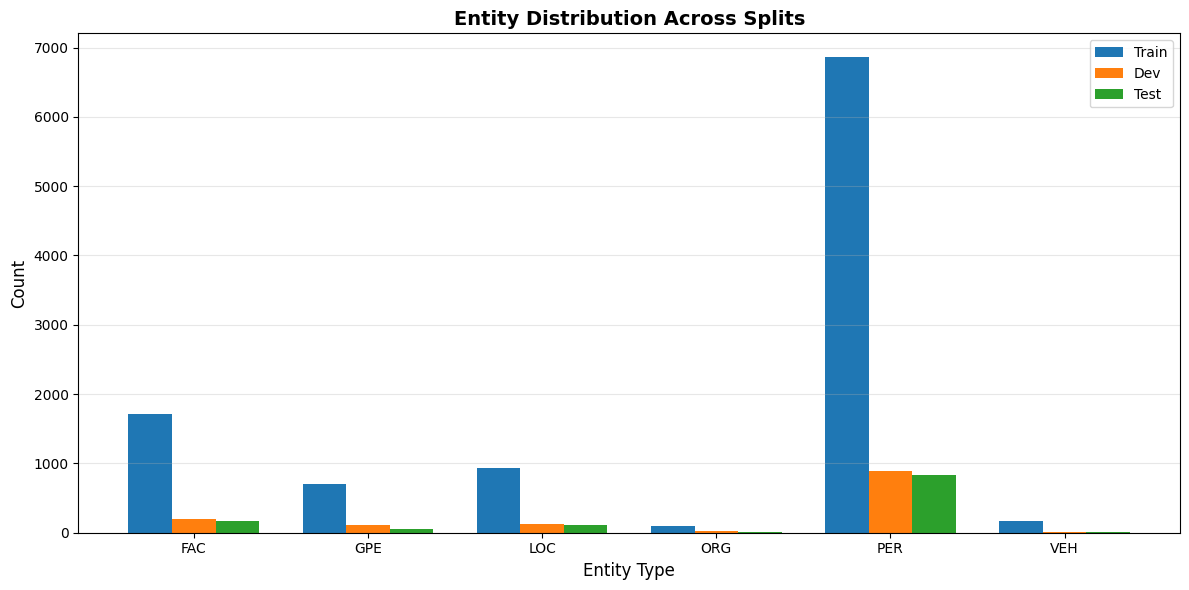

In [9]:
def plot_entity_distribution(stats_list: List[Dict], save_path: Path = None):
    """
    Create bar chart comparing entity distributions across splits.
    
    WHY: Visualizing distribution helps identify:
    - Which entities are rare (may need special handling)
    - Whether train/dev/test have similar distributions
    - Potential data quality issues
    """
    # Collect all entity types
    all_entities = set()
    for stats in stats_list:
        all_entities.update(stats['entity_distribution'].keys())
    
    entity_types = sorted(all_entities)
    
    # Prepare data for plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = range(len(entity_types))
    width = 0.25
    
    # Plot bars for each split
    for i, stats in enumerate(stats_list):
        counts = [stats['entity_distribution'].get(entity, 0) for entity in entity_types]
        offset = (i - 1) * width
        ax.bar([pos + offset for pos in x], counts, width, label=stats['split'].capitalize())
    
    ax.set_xlabel('Entity Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Entity Distribution Across Splits', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(entity_types)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved plot to {save_path}")
    
    plt.show()


# Create visualization
plot_entity_distribution(
    [train_stats, dev_stats, test_stats],
    save_path=PROCESSED_DATA_PATH.parent.parent / "results" / "entity_distribution.png"
)

## 7. Data Inspection

Examples to verify the processing worked correctly.

In [10]:
# Verification: Compare processed labels with raw HuggingFace data
from datasets import load_dataset
import random

# Load raw dataset
print("Loading raw dataset for verification...")
raw_dataset = load_dataset("coref-data/litbank_raw", "split_0")

def find_sentence_in_raw_data(tokens_to_find, raw_dataset, split='train'):
    """
    Find a sentence in the raw dataset by matching tokens.
    Returns the raw entity annotations for that sentence.
    """
    for doc in raw_dataset[split]:
        sentences = doc['sentences']
        entities = doc['entities']
        
        # Search through all sentences in this document
        for sent_idx, sentence in enumerate(sentences):
            # Check if this sentence matches our tokens
            if len(sentence) >= len(tokens_to_find):
                # Try to find a match (exact sequence)
                for start_pos in range(len(sentence) - len(tokens_to_find) + 1):
                    if sentence[start_pos:start_pos + len(tokens_to_find)] == tokens_to_find:
                        # Found a match! Return the entity annotations
                        if sent_idx < len(entities):
                            return {
                                'doc_name': doc['doc_name'],
                                'sentence': sentence,
                                'entities': entities[sent_idx],
                                'match_start': start_pos
                            }
    return None

def display_example_with_raw_comparison(example: Dict, num_tokens: int = 30):
    """
    Display processed labels alongside raw annotations from HuggingFace.
    """
    tokens = example["tokens"][:num_tokens]
    labels = example["labels"][:num_tokens]
    
    # Try to find this sentence in the raw data
    raw_info = find_sentence_in_raw_data(tokens, raw_dataset, split='train')
    
    print("\n" + "=" * 80)
    print("PROCESSED LABELS vs RAW ANNOTATIONS")
    print("=" * 80)
    
    if raw_info:
        print(f"Document: {raw_info['doc_name']}")
        print(f"\nShowing first {num_tokens} tokens:\n")
        
        # Get raw entity annotations
        raw_entities = raw_info['entities']
        match_start = raw_info['match_start']
        
        print(f"{'Token':<20} {'Processed':<15} {'Raw Annotations (all annotators)'}")
        print("-" * 80)
        
        for i, (token, label) in enumerate(zip(tokens, labels)):
            # Get raw annotations for this token
            entity_idx = match_start + i
            if entity_idx < len(raw_entities):
                raw_token_data = raw_entities[entity_idx]
                raw_bio_tags = raw_token_data['bio_tags']
                # Format: show all annotator tags
                raw_tags_str = str(raw_bio_tags)
            else:
                raw_tags_str = "N/A"
            
            # Highlight if processed label is 'O' but raw has non-O tags
            has_entity_in_raw = any(tag and tag != 'O' and tag.strip() for tag in raw_bio_tags) if entity_idx < len(raw_entities) else False
            marker = " ⚠️ MISMATCH" if label == 'O' and has_entity_in_raw else ""
            marker = " ✓" if label != 'O' else marker
            
            print(f"{token:<20} {label:<15} {raw_tags_str}{marker}")
        
        if len(example["tokens"]) > num_tokens:
            print(f"\n... ({len(example['tokens']) - num_tokens} more tokens)")
    else:
        print("\n⚠️  Could not find this sentence in raw dataset")
        print("Showing processed labels only:\n")
        
        for token, label in zip(tokens, labels):
            marker = " ✓" if label != 'O' else ""
            print(f"{token:<20} -> {label}{marker}")

# Show 3 random examples with raw data comparison
print("\n" + "="*80)
print("VERIFICATION: COMPARING PROCESSED LABELS WITH RAW HUGGINGFACE DATA")
print("="*80)
print("\nLegend:")
print("  ✓ = Entity detected")
print("  ⚠️ MISMATCH = Processed as 'O' but raw data has entity annotations")
print("")

for i in range(min(3, len(train_data))):
    example = random.choice(train_data)
    print(f"\nExample {i+1}: {len(example['tokens'])} tokens total")
    display_example_with_raw_comparison(example, num_tokens=25)

Loading raw dataset for verification...

VERIFICATION: COMPARING PROCESSED LABELS WITH RAW HUGGINGFACE DATA

Legend:
  ✓ = Entity detected
  ⚠️ MISMATCH = Processed as 'O' but raw data has entity annotations


Example 1: 51 tokens total

PROCESSED LABELS vs RAW ANNOTATIONS
Document: 233_sister_carrie_a_novel

Showing first 25 tokens:

Token                Processed       Raw Annotations (all annotators)
--------------------------------------------------------------------------------
Warm                 O               ['O', 'O', 'O', 'O', '']
with                 O               ['O', 'O', 'O', 'O', '']
the                  O               ['O', 'O', 'O', 'O', '']
fancies              O               ['O', 'O', 'O', 'O', '']
of                   O               ['O', 'O', 'O', 'O', '']
youth                O               ['O', 'O', 'O', 'O', '']
,                    O               ['O', 'O', 'O', 'O', '']
pretty               O               ['O', 'O', 'O', 'O', '']
with            

## Summary

**Files created:**
- `data/processed/train_data.json` - Training examples
- `data/processed/dev_data.json` - Development (validation) examples
- `data/processed/test_data.json` - Test examples
- `data/processed/label_mapping.json` - Label ↔ ID conversion
- `results/entity_distribution.png` - Visualization

**Next steps:**
Proceed to **Notebook 2: Model Training** to fine-tune XLM-RoBERTa on this data.